# Clasificador de Perros y Gatos

Este notebook implementa un modelo CNN para clasificar imágenes de perros y gatos.


In [18]:
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import kagglehub

## Descargar y explorar el dataset


In [19]:
path = kagglehub.dataset_download(
    "bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

data = Path(path)
print("Datos disponibles:", data)

Path to dataset files: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1
Datos disponibles: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


In [20]:
image_files = list(data.glob('**/*.jpg'))
print(f"Total de imágenes: {len(image_files)}")

Total de imágenes: 24998


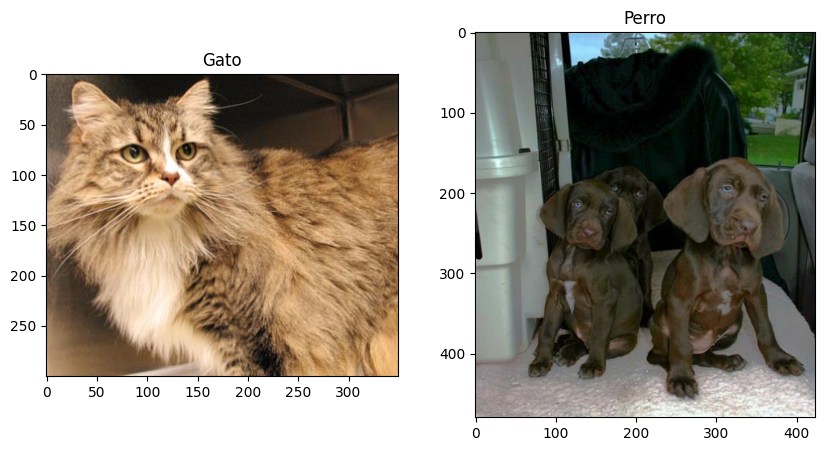

In [21]:
try:
    cat_example = list(data.glob('PetImages/Cat/*.*'))[100]
    dog_example = list(data.glob('PetImages/Dog/*.*'))[100]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Gato")
    plt.imshow(np.array(Image.open(str(cat_example))))
    
    plt.subplot(1, 2, 2)
    plt.title("Perro")
    plt.imshow(np.array(Image.open(str(dog_example))))
    plt.show()
except Exception as e:
    print(f"Error al mostrar imágenes de ejemplo: {e}")

## Preparación de los datos


In [22]:
animals = {
    'dog': list(data.glob('PetImages/Dog/*.*')),
    'cat': list(data.glob('PetImages/Cat/*.*')),
}

label = {
    'dog': 1,
    'cat': 0,
}

print(f"Imágenes de perro: {len(animals['dog'])}")
print(f"Imágenes de gato: {len(animals['cat'])}")

Imágenes de perro: 12499
Imágenes de gato: 12499


In [23]:
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_resized = cv2.resize(img, target_size)

        img_normalized = img_resized / 255.0

        return (img_normalized.astype(np.float32))
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

In [24]:
X = []
Y = []
total_images = sum(len(images) for images in animals.values())

for name, images in animals.items():
    for image in images:

        image_path = str(image).strip()
        img_processed = load_and_preprocess_image(image_path)

        if img_processed is not None:
            X.append(img_processed)
            Y.append(label[name])
            print(len(X))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
X = np.array(X)
Y = np.array(Y)

print(f"Forma del conjunto: {X.shape}")
print(f"Distribución de clases: {np.bincount(Y)}")

Forma del conjunto: (24946, 150, 150, 3)
Distribución de clases: [12476 12470]


## División de los datos y creación del modelo


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y)

print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (19956, 150, 150, 3), (19956,)
Conjunto de prueba: (4990, 150, 150, 3), (4990,)


In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [28]:
def build_model(input_shape=(150, 150, 3)):
    model = Sequential([
        data_augmentation,

        layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [29]:
model = build_model(input_shape=X_train[0].shape)
model.summary()

c:\projects\python\clasificator-cat-dogs\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo


In [30]:
callbacks = [
    EarlyStopping(patience=10,
                  restore_best_weights=True,
                  monitor='val_accuracy'),

    ReduceLROnPlateau(factor=0.2,
                      patience=5,
                      min_lr=1e-6,
                      monitor='val_loss')
]

In [31]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 133s 260ms/step - accuracy: 0.5467 - loss: 1.2560 - val_accuracy: 0.6711 - val_loss: 0.7652 - learning_rate: 1.0000e-04
Epoch 2/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 129s 259ms/step - accuracy: 0.6826 - loss: 0.7432 - val_accuracy: 0.7340 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 3/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 131s 263ms/step - accuracy: 0.7010 - loss: 0.6526 - val_accuracy: 0.7505 - val_loss: 0.5729 - learning_rate: 1.0000e-04
Epoch 4/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 129s 258ms/step - accuracy: 0.7179 - loss: 0.6021 - val_accuracy: 0.7385 - val_loss: 0.5668 - learning_rate: 1.0000e-04
Epoch 5/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 126s 253ms/step - accuracy: 0.7369 - loss: 0.5750 - val_accuracy: 0.7683 - val_loss: 0.5169 - learning_rate: 1.0000e-04
Epoch 6/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 125s 251ms/step - accuracy: 0.7531 - loss: 0.5429 - val_accuracy: 0.7693 - val_loss: 0.5187 - learning_rate: 1.0000e-04
Epoch 7/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluación del modelo


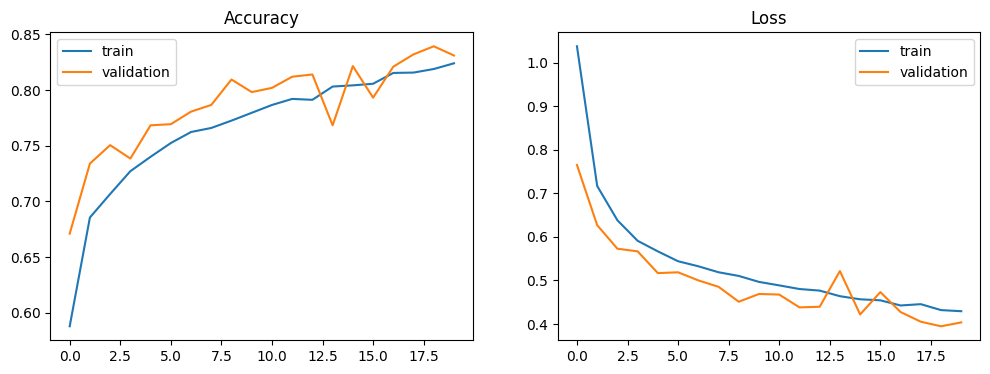

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.show()

In [36]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8486 - loss: 0.3989
Precisión en el conjunto de prueba: 0.8507


In [37]:
model.save('models/cat_dog_classifier_improved.h5')